# QuaNNTO Example — MNIST (CV-preprocessed) Multi-Class Classification with a CV-QONN

This notebook is an **end-to-end multi-class classification example** for the `QuaNNTO` library (branch `revisited-code`).

## Goal
Train a CV-QONN to classify a subset of MNIST digits using a **continuous-variable preprocessing** step that maps each image to a low-dimensional latent vector.

### Pipeline
1. **Continuize** MNIST images into a latent space of dimension `n_inputs` using either:
   - PCA (`continuize_method = 'pca'`), or
   - an Autoencoder (`continuize_method = 'encoding'` / autoencoder-based latent).
2. **Train** a CV-QONN classifier with cross-entropy loss.
3. **Evaluate** accuracy on the full dataset.
4. **Plot** confusion matrix + per-class accuracy summaries.

---
## Notes
- The dataset is cached under the QuaNNTO datasets directory using `quannto.utils.path_utils`.
- This notebook uses LaTeX-friendly operator labels: $\hat a$ (subtraction) and $\hat a^\dagger$ (addition).
- For reproducibility, we fix the random seed (`np.random.seed(42)`).


In [1]:
import sys
from pathlib import Path

# set repo_root to the parent directory to find 'quannto' modules
repo_root = Path.cwd().resolve().parent  
sys.path.insert(0, str(repo_root))

In [2]:
from functools import partial
import numpy as np
import os.path

from quannto.core.qnn_trainers import *
from quannto.utils.path_utils import (
    datasets_dir,
    models_testing_results_path,
    models_train_losses_path,
    models_valid_losses_path,
)
from quannto.utils.results_utils import *
from quannto.core.data_processors import *
from quannto.core.loss_functions import *

np.random.seed(42)


2026-02-18 18:59:37.110818: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-18 18:59:37.110852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-18 18:59:37.111617: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-18 18:59:37.643829: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1) Hyperparameters

We use a single architecture in this example:
- `N = 5` modes
- `L = 2` layers
- photon subtraction on two modes per layer (as specified by `qnns_ladder_modes`)

The classifier takes `n_inputs = 5` real inputs and outputs `n_outputs = 5` values that are postprocessed into class predictions.


In [3]:
# === HYPERPARAMETERS DEFINITION ===
qnns_modes = [6, 6]
qnns_ladder_modes = [[[1]], [[5]]]
qnns_layers = [1, 1]
qnns_is_addition = [False, False]

include_initial_squeezing = False
include_initial_mixing = False
is_passive_gaussian = False

n_inputs = 5
n_outputs = 5
observable = 'position'

in_norm_ranges = [(-3, 3)] * len(qnns_modes)   # or None
out_norm_ranges = [(1, 3)] * len(qnns_modes)  # or None


## 2) Optimizer settings

We train with:
- `build_and_train_model`
- cross-entropy loss
- a small basinhopping budget (`basinhopping_iters = 1`) for this demo


In [4]:
# === OPTIMIZER SETTINGS ===
optimize = build_and_train_model
loss_function = cross_entropy
basinhopping_iters = 0
params = None


## 3) Dataset settings (CV-preprocessed MNIST)

We choose a subset of MNIST classes and map the images into a continuous latent space of dimension `n_inputs`.

### Key settings
- `categories`: subset of digits to classify
- `continuize_method`: PCA or autoencoder-based latent
- `dataset_size`: number of training samples
- `validset_size`: number of validation samples

The dataset is cached under the QuaNNTO datasets directory.


In [5]:
# === DATASET SETTINGS ===
categories = [0, 1, 2, 3, 4]
num_cats = len(categories)

dataset_size = 75 * num_cats
validset_size = 20 * num_cats

continuize_method = 'pca'  # 'pca' or 'encoding' for Autoencoder

task_name = f"mnist_{continuize_method}_{n_inputs}lat_{num_cats}cats"
dataset_dir = str(datasets_dir() / task_name)

print("task_name:", task_name)
print("dataset_dir prefix:", dataset_dir)


task_name: mnist_pca_5lat_5cats
dataset_dir prefix: /home/tkrasimi/QuanticGit/Quannto/datasets/mnist_pca_5lat_5cats


## 4) Load or build the dataset

If the dataset cache is present, we load it. Otherwise we build it using:
- `pca_mnist(n_inputs, categories)` or
- `autoencoder_mnist(n_inputs, categories)`

We additionally enforce that each latent dimension has a positive range (as in the original script).


In [6]:
# 1) FULL DATASET: Load or build (and save) a CV-preprocessed MNIST dataset
if os.path.isfile(dataset_dir + "_inputs.npy"):
    with open(dataset_dir + "_inputs.npy", "rb") as f:
        inputs = np.load(f)
    with open(dataset_dir + "_outputs.npy", "rb") as f:
        outputs = np.load(f)
    dataset = [inputs, outputs]
    input_ranges = np.array([
        (np.min(dataset[0][:, col]), np.max(dataset[0][:, col]))
        for col in range(len(dataset[0][0]))
    ])
else:
    while True:
        dataset = pca_mnist(n_inputs, categories) if continuize_method == 'pca' else autoencoder_mnist(n_inputs, categories)
        input_ranges = np.array([
            (np.min(dataset[0][:, col]), np.max(dataset[0][:, col]))
            for col in range(len(dataset[0][0]))
        ])
        # Keep sampling until all feature ranges have positive max (original script behavior)
        if np.all(input_ranges[:, -1] > 0):
            break

    with open(dataset_dir + "_inputs.npy", "wb") as f:
        np.save(f, dataset[0])
    with open(dataset_dir + "_outputs.npy", "wb") as f:
        np.save(f, dataset[1])

# Shuffle once for reproducibility
shuffling = np.random.permutation(len(dataset[0]))
shuffled_dataset = [dataset[0][shuffling], dataset[1][shuffling]]

# 2) TRAINING DATASET
train_dataset = (shuffled_dataset[0][:dataset_size], shuffled_dataset[1][:dataset_size])

# 3) VALIDATION DATASET
valid_dataset = (
    shuffled_dataset[0][dataset_size: dataset_size + validset_size],
    shuffled_dataset[1][dataset_size: dataset_size + validset_size],
)

# 4) TESTING DATASET: use the entire dataset
test_dataset = (dataset[0], dataset[1])
test_outputs_cats = dataset[1].reshape((len(dataset[1])))

print("Dataset shapes:")
print("  inputs:", dataset[0].shape)
print("  outputs:", dataset[1].shape)
print("Train shapes:", train_dataset[0].shape, train_dataset[1].shape)
print("Valid shapes:", valid_dataset[0].shape, valid_dataset[1].shape)


Dataset shapes:
  inputs: (5139, 5)
  outputs: (5139, 1)
Train shapes: (375, 5) (375, 1)
Valid shapes: (100, 5) (100, 1)


## 5) Train and evaluate the CV-QONN

We train one model (single configuration) and evaluate predictions on the full dataset.

The postprocessing pipeline is:
1. `softmax_discretization`
2. `greatest_probability`
3. `np.ravel`

So `qnn.test_model(...)` returns **class predictions** (not raw logits).


In [7]:
qnns = []
train_losses = []
valid_losses = []
qnns_preds = []
qnns_accuracies = []
legend_labels = []

for (N, l, ladder_modes, is_addition, in_norm_range, out_norm_range) in zip(
    qnns_modes,
    qnns_layers,
    qnns_ladder_modes,
    qnns_is_addition,
    in_norm_ranges,
    out_norm_ranges,
):
    # === NAME AND LEGEND ===
    model_name = (
        task_name
        + "_N" + str(N)
        + "_L" + str(l)
        + ("_add" if is_addition else "_sub")
        + str(ladder_modes)
        + "_in" + str(in_norm_range)
        + "_out" + str(out_norm_range)
    )

    nongauss_op = r"$\hat a^\dagger$" if is_addition else r"$\hat a$"
    # For multi-list ladder modes (e.g., [[0],[1]]) show all affected modes (1-indexed)
    ladder_modes_disp = [np.array(m) + 1 for m in ladder_modes]
    legend_labels.append(f"N={N}, L={l}, {nongauss_op} in modes {ladder_modes_disp}")

    # === PREPROCESSORS AND POSTPROCESSORS ===
    in_preprocessors = []
    if in_norm_range is not None:
        in_preprocessors.append(
            partial(rescale_set_with_ranges, data_ranges=input_ranges, rescale_range=in_norm_range)
        )
    in_preprocessors.append(partial(pad_data, length=2 * N))

    out_preprocessors = []
    out_preprocessors.append(partial(one_hot_encoding, num_cats=num_cats))
    if out_norm_range is not None:
        out_preprocessors.append(
            partial(rescale_data, data_range=(0, 1), scale_data_range=out_norm_range)
        )

    postprocessors = []
    postprocessors.append(partial(softmax_discretization))
    postprocessors.append(partial(greatest_probability))
    postprocessors.append(partial(np.ravel))

    # === BUILD, TRAIN AND TEST ===
    qnn, train_loss, valid_loss = optimize(
        model_name,
        N,
        l,
        n_inputs,
        n_outputs,
        ladder_modes,
        is_addition,
        observable,
        include_initial_squeezing,
        include_initial_mixing,
        is_passive_gaussian,
        train_dataset,
        valid_dataset,
        loss_function,
        basinhopping_iters,
        in_preprocessors,
        out_preprocessors,
        postprocessors,
        init_pars=params,
    )

    qnn_preds, norms, loss_value = qnn.test_model(test_dataset[0], test_dataset[1], loss_function)
    qnn_hits = np.equal(qnn_preds, test_outputs_cats).sum()
    accuracy = qnn_hits / len(qnn_preds)

    qnns.append(qnn)
    train_losses.append(train_loss.copy())
    valid_losses.append(valid_loss.copy())
    qnns_preds.append(qnn_preds.copy())
    qnns_accuracies.append(accuracy)

    print(
        f"==========\nACCURACY FOR N={N}, L={l}, LADDER MODES={ladder_modes}: "
        f"{qnn_hits}/{len(qnn_preds)} = {accuracy}\n==========\n"
    )

    # === SAVE RESULTS ===
    np.save(models_train_losses_path(model_name, "npy"), np.array(train_loss))
    np.save(models_valid_losses_path(model_name, "npy"), np.array(valid_loss))
    np.save(models_testing_results_path(model_name, "npy"), np.array(qnn_preds))

    # Confusion matrix per model
    plot_confusion_matrix(model_name, test_outputs_cats, qnn_preds)


Number of tunable parameters: 90
Number of terms for each trace: [1 1 1 1 1 1]
Training loss: 12.671437117706025
Validation loss: 12.75889140239732
Training loss: 11.726211539871825
Validation loss: 11.780943459933935
Training loss: 11.29080865488116
Validation loss: 11.33371222570358
Training loss: 11.01805632151266
Validation loss: 11.039289868928659
Training loss: 10.8408973576211
Validation loss: 10.866145896422656
Training loss: 10.752553658368514
Validation loss: 10.770795943371304
Training loss: 10.666624023968085
Validation loss: 10.69155090875541
Training loss: 10.628750311157786
Validation loss: 10.6460062031673
Training loss: 10.615077654050593
Validation loss: 10.637166580846731
Training loss: 10.609110869983596
Validation loss: 10.631953492910263
Training loss: 10.607877209132797
Validation loss: 10.629607312793578
Training loss: 10.606069747655015
Validation loss: 10.625487791257488
Training loss: 10.604474096767488
Validation loss: 10.621820166606312
Training loss: 10.60

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

## 6) Per-class accuracy summaries

We plot per-class accuracy in two complementary styles:
- a histogram/bar-style per-class accuracy,
- markers showing per-class accuracy along with the overall model accuracy.


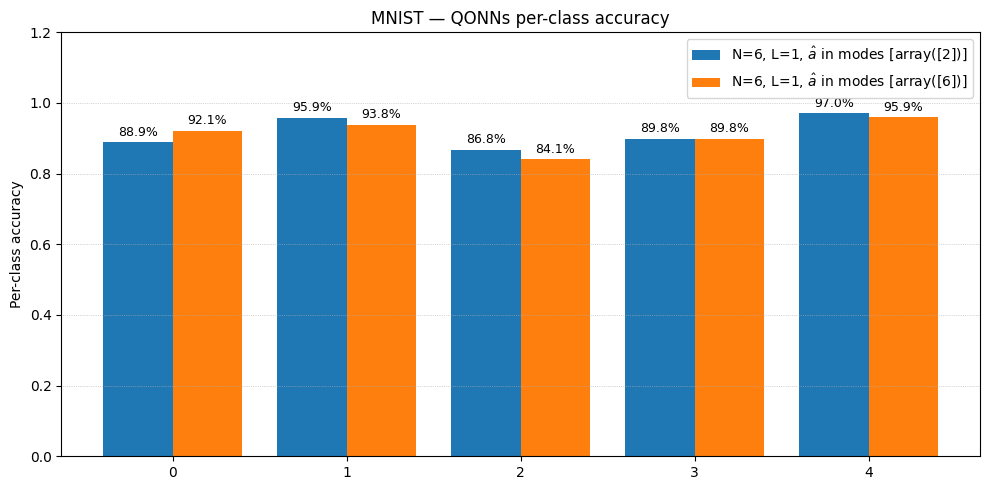

<Figure size 640x480 with 0 Axes>

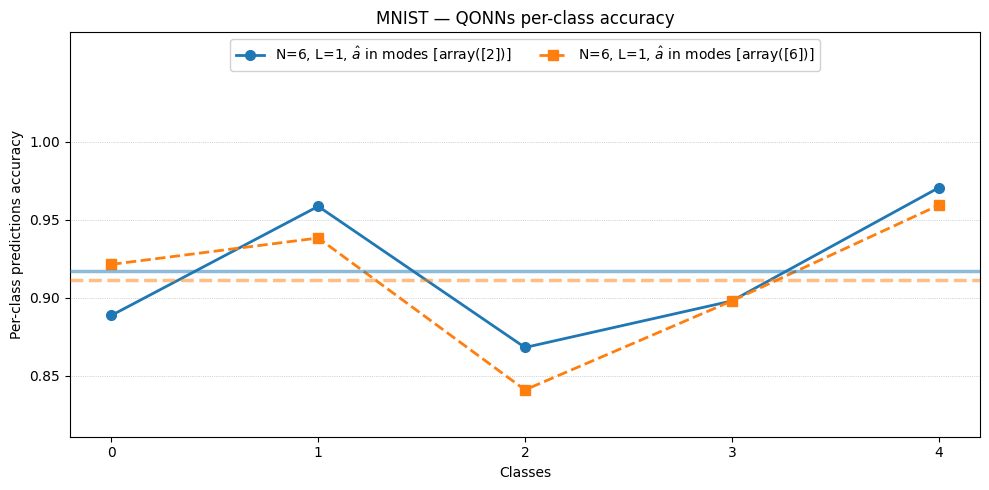

=== ACCURACIES ACHIEVED ===
N=6, L=1, $\hat a$ in modes [array([2])]: 0.9174936758124149
N=6, L=1, $\hat a$ in modes [array([6])]: 0.9116559641953688


<Figure size 640x480 with 0 Axes>

In [8]:
nongauss_ops = [r"$\hat a^\dagger$" if is_addition else r"$\hat a$" for is_addition in qnns_is_addition]
filename = (
    task_name
    + "_N" + str(qnns_modes)
    + "_L" + str(qnns_layers)
    + "_ph" + str(nongauss_ops)
    + str(qnns_ladder_modes)
)

fig, ax, acc = plot_per_class_accuracy_hist(
    categories,
    test_outputs_cats,
    qnns_preds,
    legend_labels=legend_labels,
    filename=filename,
    title="MNIST — QONNs per-class accuracy",
)

fig, ax, acc = plot_per_class_accuracy_markers(
    categories,
    test_outputs_cats,
    qnns_preds,
    qnns_accuracies,
    legend_labels=legend_labels,
    filename=filename,
    title="MNIST — QONNs per-class accuracy",
)


## Next steps

- Increase `basinhopping_iters` for better optimization.
- Try a different class subset (e.g., `[0,1,2,3,4,5,6,7,8,9]`) if your preprocessing supports it.
- Compare PCA vs autoencoder latents by switching `continuize_method`.
- Sweep `N`, `L`, and ladder-mode patterns to study accuracy vs resources.
